<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Хакатоним-ФинТех" data-toc-modified-id="Хакатоним-ФинТех-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Хакатоним ФинТех</a></span><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Содержание</a></span></li><li><span><a href="#Загрузка-библиотек--" data-toc-modified-id="Загрузка-библиотек---1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка библиотек  <a class="anchor" id="ch1"></a></a></span></li><li><span><a href="#Сбор-и-анализ-данных--" data-toc-modified-id="Сбор-и-анализ-данных---1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Сбор и анализ данных  <a class="anchor" id="ch2"></a></a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных--" data-toc-modified-id="Загрузка-данных---1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Загрузка данных  <a class="anchor" id="ch21"></a></a></span></li><li><span><a href="#Анализ-тренировочной-выборки--" data-toc-modified-id="Анализ-тренировочной-выборки---1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Анализ тренировочной выборки  <a class="anchor" id="ch22"></a></a></span></li><li><span><a href="#df_train-" data-toc-modified-id="df_train--1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>df_train <a class="anchor" id="ch221"></a></a></span></li><li><span><a href="#df_socdem-" data-toc-modified-id="df_socdem--1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>df_socdem <a class="anchor" id="ch222"></a></a></span></li><li><span><a href="#df_balance-" data-toc-modified-id="df_balance--1.3.5"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>df_balance <a class="anchor" id="ch223"></a></a></span></li><li><span><a href="#df_stories_texts-" data-toc-modified-id="df_stories_texts--1.3.6"><span class="toc-item-num">1.3.6&nbsp;&nbsp;</span>df_stories_texts <a class="anchor" id="ch224"></a></a></span></li><li><span><a href="#df_stories_logs-" data-toc-modified-id="df_stories_logs--1.3.7"><span class="toc-item-num">1.3.7&nbsp;&nbsp;</span>df_stories_logs <a class="anchor" id="ch225"></a></a></span></li><li><span><a href="#df_products-" data-toc-modified-id="df_products--1.3.8"><span class="toc-item-num">1.3.8&nbsp;&nbsp;</span>df_products <a class="anchor" id="ch226"></a></a></span></li></ul></li><li><span><a href="#Визуализация-данных--" data-toc-modified-id="Визуализация-данных---1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Визуализация данных  <a class="anchor" id="ch4"></a></a></span></li><li><span><a href="#Feature-Engineering--" data-toc-modified-id="Feature-Engineering---1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Feature Engineering  <a class="anchor" id="ch9"></a></a></span><ul class="toc-item"><li><span><a href="#Признак-№1-" data-toc-modified-id="Признак-№1--1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Признак №1 <a class="anchor" id="ch91"></a></a></span></li><li><span><a href="#Признак-№2-" data-toc-modified-id="Признак-№2--1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Признак №2 <a class="anchor" id="ch92"></a></a></span></li><li><span><a href="#Признак-№3-" data-toc-modified-id="Признак-№3--1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Признак №3 <a class="anchor" id="ch93"></a></a></span></li><li><span><a href="#Признак-№4-" data-toc-modified-id="Признак-№4--1.5.4"><span class="toc-item-num">1.5.4&nbsp;&nbsp;</span>Признак №4 <a class="anchor" id="ch94"></a></a></span></li><li><span><a href="#Признак-№5-" data-toc-modified-id="Признак-№5--1.5.5"><span class="toc-item-num">1.5.5&nbsp;&nbsp;</span>Признак №5 <a class="anchor" id="ch95"></a></a></span></li><li><span><a href="#Признак-№6-" data-toc-modified-id="Признак-№6--1.5.6"><span class="toc-item-num">1.5.6&nbsp;&nbsp;</span>Признак №6 <a class="anchor" id="ch96"></a></a></span></li><li><span><a href="#Признак-№7-" data-toc-modified-id="Признак-№7--1.5.7"><span class="toc-item-num">1.5.7&nbsp;&nbsp;</span>Признак №7 <a class="anchor" id="ch97"></a></a></span></li><li><span><a href="#Признак-№8-" data-toc-modified-id="Признак-№8--1.5.8"><span class="toc-item-num">1.5.8&nbsp;&nbsp;</span>Признак №8 <a class="anchor" id="ch98"></a></a></span></li><li><span><a href="#Признак-№9-(ARIMA)-" data-toc-modified-id="Признак-№9-(ARIMA)--1.5.9"><span class="toc-item-num">1.5.9&nbsp;&nbsp;</span>Признак №9 (ARIMA) <a class="anchor" id="ch99"></a></a></span></li></ul></li><li><span><a href="#Создание-единой-таблицы--" data-toc-modified-id="Создание-единой-таблицы---1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Создание единой таблицы  <a class="anchor" id="ch10"></a></a></span></li><li><span><a href="#Выбор-бизнес-метрик--" data-toc-modified-id="Выбор-бизнес-метрик---1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Выбор бизнес-метрик  <a class="anchor" id="ch11"></a></a></span><ul class="toc-item"><li><span><a href="#Бизнес-метрика-№1-" data-toc-modified-id="Бизнес-метрика-№1--1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>Бизнес-метрика №1 <a class="anchor" id="ch11_1"></a></a></span><ul class="toc-item"><li><span><a href="#Подсчёт-бизнес-метрики" data-toc-modified-id="Подсчёт-бизнес-метрики-1.7.1.1"><span class="toc-item-num">1.7.1.1&nbsp;&nbsp;</span>Подсчёт бизнес-метрики</a></span></li></ul></li><li><span><a href="#Бизнес-метрика-№2-" data-toc-modified-id="Бизнес-метрика-№2--1.7.2"><span class="toc-item-num">1.7.2&nbsp;&nbsp;</span>Бизнес-метрика №2 <a class="anchor" id="ch11_2"></a></a></span><ul class="toc-item"><li><span><a href="#Подсчёт-бизнес-метрики" data-toc-modified-id="Подсчёт-бизнес-метрики-1.7.2.1"><span class="toc-item-num">1.7.2.1&nbsp;&nbsp;</span>Подсчёт бизнес-метрики</a></span></li></ul></li><li><span><a href="#Бизнес-метрика-№3-" data-toc-modified-id="Бизнес-метрика-№3--1.7.3"><span class="toc-item-num">1.7.3&nbsp;&nbsp;</span>Бизнес-метрика №3 <a class="anchor" id="ch11_3"></a></a></span><ul class="toc-item"><li><span><a href="#Подсчёт-бизнес-метрики" data-toc-modified-id="Подсчёт-бизнес-метрики-1.7.3.1"><span class="toc-item-num">1.7.3.1&nbsp;&nbsp;</span>Подсчёт бизнес-метрики</a></span></li></ul></li><li><span><a href="#Дополнительная-бизнес-метрика-" data-toc-modified-id="Дополнительная-бизнес-метрика--1.7.4"><span class="toc-item-num">1.7.4&nbsp;&nbsp;</span>Дополнительная бизнес-метрика <a class="anchor" id="ch11_4"></a></a></span></li></ul></li></ul></li></ul></div>

# Хакатоним ФинТех

## Содержание

- [Загрузка библиотек](#ch1)
- [Сбор и анализ данных](#ch2)
    - [Загрузка данных](#ch21)
    - [Анализ тренировочной выборки](#ch22)
      - [df_train](#ch221)
          - [Первичный анализ](#ch2211)
          - [Приведение категориальных признаков к числовому виду](#ch2212)
          - [Заполнение пропусков](#ch2213)
      - [df_socdem](#ch222)
          - [Первичный анализ](#ch2221)
          - [Приведение категориальных признаков к числовому виду](#ch2222)
          - [Заполнение пропусков](#ch2223)
      - [df_balance](#ch223)
          - [Первичный анализ](#ch2231)
          - [Заполнение пропусков](#ch2233)
      - [df_stories_texts](#ch224)
          - [Первичный анализ](#ch2241)
          - [Заполнение пропусков](#ch2243)
      - [df_stories_logs](#ch225)
          - [Первичный анализ](#ch2251)
          - [Приведение категориальных признаков к числовому виду](#ch2252)
          - [Заполнение пропусков](#ch2253)
      - [df_products](#ch226)
          - [Первичный анализ](#ch2261)
          - [Заполнение пропусков](#ch2263)
- [Feature Engineering](#ch9)
    - [Признак №1](#ch91)
    - [Признак №2](#ch92)
    - [Признак №3](#ch93)
    - [Признак №4](#ch94)
    - [Признак №5](#ch95)
    - [Признак №6](#ch96)
    - [Признак №7](#ch97)
    - [Признак №8](#ch98)
    - [Признак №9 (ARIMA)](#ch99)
- [Создание единой таблицы](#ch3)
- [Визуализация данных КАМРОН](#ch4)
- [Стандартизация признаков](#ch7)
- [Кластеризация АЛИНА](#ch10)
- [Выбор бизнес-метрик](#ch11)
    - [Бизнес-метрика №1](#ch11_1)
    - [Бизнес-метрика №2](#ch11_2)
    - [Бизнес-метрика №3](#ch11_3)
    - [Дополнительная бизнес-метрика](#ch11_4)
- [Метрики задач машинного обучения, соответствующие цели задачи](#ch12)
- [Предсказательная модель](#ch13)
    - [Multi-output regressor](#ch131)
- [Тестирование модели на тестовых данных](#ch15)
- [Возможные улучшения](#ch15)
- [Вывод](#ch16)

## Загрузка библиотек  <a class="anchor" id="ch1"></a>

In [11]:
!conda install seaborn==0.11 -y
!pip install pingouin
!pip install plotly
!pip install sklearn
!pip install graphviz
!pip install matplotlib==3.1.1 
!pip install pdpbox==0.2.1 
!pip install catboost==0.24.3 
!pip install scipy==1.4.1
!pip install statsmodels
!pip install statsmodels==0.11.1

     |████████████████████████████████| 37.8 MB 930 kB/s eta 0:00:01
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=8464462 sha256=8d0572e90ef2b385f8a4d40ad03c29691c2cb0d89b5a845d83c78f8df1077630
  Stored in directory: /Users/anton/Library/Caches/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce631dfe5
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [16]:
# загрузка библиотек
from IPython import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import datetime
from sklearn import preprocessing
import statistics
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
#sns.set_theme(style="whitegrid")
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [132]:
def removing_outliers(column,frame, count = 0,total_outliers = 0, alpha = 1.5,max_iter = 5):
        """
        Метод удаления выбросов с помощью межквартильного размаха

        Параметры:
        - column: Имя столбца, где нужно найти выбросы
        - frame: Фрейм, где находится столбец для анализа
        - count: Количество рекурсивных циклов проверки 
        - total_outliers: Общая сумма выбросов, найденных за все циклы проверки
        - alpha: Коэфициент при вычислении интервала
        - max_iter: максимальное количество циклов функции

        Возвращет:
        - frame: Обработанный фрейм
        - leng: Количесвто выбросов на цикле
        - total_outliers: Общее количество выбросов
        """
        # Получим квантиль 25%
        q25=np.array(frame[column].describe(percentiles=[.25,.75]).loc['25%'])
        # Получим квантиль 75%
        q75=np.array(frame[column].describe(percentiles=[.25,.75]).loc['75%'])
        # Получим первую границу
        first_part=q25-alpha*(q75-q25)
        # Получим 2 границу
        second_part=q75+alpha*(q75-q25)
        # Получим все значения, удолитворяющих промежутку
        prep_frame = frame[(frame[column] > first_part) & (frame[column] < second_part)]
        # Подсчет количсва удаленных выбросов
        leng = frame.shape[0] - prep_frame.shape[0]
        # Увеление счетчика циклов
        count += 1
        # Заменим исходную таблицу обработанной
        frame = prep_frame.copy()
        # Удалим не нужную таблицу
        del prep_frame
        # Проверим условия выхода
        if leng > 0 and count < max_iter:
            frame,leng,total_outliers = removing_outliers(column,frame, count,total_outliers+leng)
        else:
            print('Количество строк, выбранных для удаления {}: {}. Количество итераций {}'.format(column,total_outliers,count),end = "\n\n")
        return frame,leng,total_outliers

## Сбор и анализ данных  <a class="anchor" id="ch2"></a>

### Загрузка данных  <a class="anchor" id="ch21"></a>

In [17]:
!wget  -O 'avk_hackathon_data_story_texts.csv' -q 'https://www.dropbox.com/s/ki8zzf51uxtn39h/avk_hackathon_data_story_texts.csv?dl=0'
!wget  -O 'avk_hackathon_data_party_x_socdem.csv' -q 'https://www.dropbox.com/s/cjlo1edjbnxvp88/avk_hackathon_data_party_x_socdem.csv?dl=0'
!wget  -O 'avk_hackathon_data_party_products.csv' -q 'https://www.dropbox.com/s/vb8fe4yhshd401y/avk_hackathon_data_party_products.csv?dl=0'
!wget  -O 'avk_hackathon_data_account_x_balance.csv' -q 'https://www.dropbox.com/s/i94cotxyti8y7ir/avk_hackathon_data_account_x_balance.csv?dl=0'
!wget  -O 'avk_hackathon_data_train_transactions.csv' -q 'https://www.dropbox.com/s/ui8x3dtpjht3560/avk_hackathon_data_train_transactions.csv?dl=0'
!wget  -O 'avk_hackathon_data_story_logs.csv' -q 'https://www.dropbox.com/s/8oexjpfpn8nqrnn/avk_hackathon_data_story_logs.csv?dl=0'
!wget  -O 'avk_hackathon_data_test_transactions.csv' -q 'https://www.dropbox.com/s/97ik1n6y3osrxug/avk_hackathon_data_test_transactions.csv?dl=0'

zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget


In [186]:
df_test = pd.read_csv('avk_hackathon_data_test_transactions.csv', encoding='utf-8')
df_story_texts= pd.read_csv('avk_hackathon_data_story_texts.csv')
df_socdem = pd.read_csv('avk_hackathon_data_party_x_socdem.csv')
df_products = pd.read_csv('avk_hackathon_data_party_products.csv')
df_balance = pd.read_csv('avk_hackathon_data_account_x_balance.csv')
df_train = pd.read_csv('avk_hackathon_data_train_transactions.csv')
df_stories_logs = pd.read_csv('avk_hackathon_data_story_logs.csv')

In [22]:
# df_balance = pd.read_csv(r'C:\ВШЭ 3 курс\FINOdays\tinkoff_hackathon_data\tinkoff_hackathon_data\avk_hackathon_data_account_x_balance.csv')
# df_products = pd.read_csv(r'C:\ВШЭ 3 курс\FINOdays\tinkoff_hackathon_data\tinkoff_hackathon_data\avk_hackathon_data_party_products.csv')
# df_socdem = pd.read_csv(r'C:\ВШЭ 3 курс\FINOdays\tinkoff_hackathon_data\tinkoff_hackathon_data\avk_hackathon_data_party_x_socdem.csv')
# df_stories_logs = pd.read_csv(r'C:\ВШЭ 3 курс\FINOdays\tinkoff_hackathon_data\tinkoff_hackathon_data\avk_hackathon_data_story_logs.csv')
# df_story_texts = pd.read_csv(r'C:\ВШЭ 3 курс\FINOdays\tinkoff_hackathon_data\tinkoff_hackathon_data\avk_hackathon_data_story_texts.csv')
# df_test = pd.read_csv(r'C:\ВШЭ 3 курс\FINOdays\tinkoff_hackathon_data\tinkoff_hackathon_data\avk_hackathon_data_test_transactions.csv')
# df_train = pd.read_csv(r'C:\ВШЭ 3 курс\FINOdays\tinkoff_hackathon_data\tinkoff_hackathon_data\avk_hackathon_data_train_transactions.csv')

### Анализ тренировочной выборки  <a class="anchor" id="ch22"></a>

### df_train <a class="anchor" id="ch221"></a>

В данной таблице содержится информация о совершенных пользователями транзакциях, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>account_rk</strong> - уникальный идентификационный номер счета</li>
<li><strong>financial_account_type_cd</strong> - тип карты (дебетовая/кредитовая)</li>
<li><strong>transaction_dttm</strong> - день совершения операции в формате ГГГГ-ММ-ДД</li>
<li><strong>transaction_amt_rur</strong> - сумма транзакции в рублях</li>
<li><strong>merchant_rk	</strong> - идентификационный номер мерчант-аккаунта (оборудования для приема платежей)</li>  
<li><strong>merchant_type</strong> - идентификационный номер типа мерчанта</li> 
<li><strong>merchant_group_rk</strong> - идентификационный номер мерчант-группы, обслуживающей соответствующий мерчант-аккаунт</li>
<li><strong>category	</strong> - категория транзакции</li>  
</ul>

In [134]:
df_train.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры
1,63404,72991,1,2019-01-01,Покупка,410.00,887248.0,330.0,725.0,Фаст Фуд
2,24789,23517,2,2019-01-01,Покупка,701.44,830014.0,291.0,NaN,Супермаркеты
3,57970,64838,2,2019-01-01,Покупка,6203.70,363834.0,278.0,454.0,Дом/Ремонт
4,12232,11591,2,2019-01-01,Покупка,734.53,85919.0,286.0,878.0,Супермаркеты


Удалим колонки, связанные со счетом. При входе в приложение "Тинькофф" в раздел, где можно выбрать категории для кэшбэка, пользователю предлагается выбрать 3 категории. Его выбор не зависит от его счета (account_rk), а зависит от того, с какого аккаунта он зашел (party_rk). Пэтому мы имеем право удалить колонки, связанные со счетом. 

In [135]:
df_train = df_train.drop(['account_rk','merchant_rk','merchant_group_rk', 'merchant_type', 'transaction_type_desc'], axis = 1)

##### Первичный анализ <a class="anchor" id="ch2211"></a>

In [136]:
print('Количество строк: {}, количество столбцов: {}'.format(df_train.shape[0], df_train.shape[1]))

Количество строк: 11987617, количество столбцов: 5


Посмотрим на типы переменных, чтобы корректно выполнять операции с ними. 

In [137]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11987617 entries, 0 to 11987616
Data columns (total 5 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   party_rk                   int64  
 1   financial_account_type_cd  int64  
 2   transaction_dttm           object 
 3   transaction_amt_rur        float64
 4   category                   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 457.3+ MB


Переведем столбец с датами транзакций в тип datetime. 

In [138]:
df_train['transaction_dttm'] = pd.to_datetime(df_train['transaction_dttm'])

Проверим, какие значения может принимать категориальный признак 'category'.

In [139]:
df_train['category'].value_counts().reset_index()

,index,category
0,Супермаркеты,3938925
1,Фаст Фуд,1007549
2,Транспорт,839906
3,Финансовые услуги,787258
4,Разные товары,531127
5,Рестораны,401255
6,Топливо,398397
7,Аптеки,311316
8,Наличные,271948
9,Дом/Ремонт,268370


Все значения категорий различные, нет недочетов в плане написания/лишних пробелов и тд.

Для более детального понимания данных, посмотрим на их основные характеристики. 

In [140]:
df_train.describe().round(3)

,party_rk,financial_account_type_cd,transaction_amt_rur
count,1.198762e+07,11987617.00,1.198761e+07
mean,4.300785e+04,1.67,3.186888e+03
std,2.540438e+04,0.47,2.447061e+04
min,1.000000e+00,1.00,1.000000e+01
25%,2.117500e+04,1.00,1.599000e+02
50%,4.216800e+04,2.00,3.910000e+02
75%,6.319900e+04,2.00,1.225000e+03
max,9.461000e+04,2.00,2.000010e+07


In [141]:
a = min(df_train['transaction_amt_rur'])
b = max(df_train['transaction_amt_rur'])
c = df_train['transaction_amt_rur'].mean()
print('Минимальное значение: {}, максимальное значение: {}, среднее значение: {}'.format(a, b, c))

Минимальное значение: 10.0, максимальное значение: 20000100.0, среднее значение: 3186.8884018274944


Минимальное и максимальное значение транзакций сильно отличаются от среднего. Можно, предположить, что в столбце 'transaction_amt_rur' присутствуют выбросы.

##### Удаление выбросов <a class="anchor" id="ch2213"></a>

Есть несколько способов удаления выбросов: через z-score, через квантили и KMean. Но самый простой для понимания способ - через квантили (IQR), поэтому будем использовать его. 

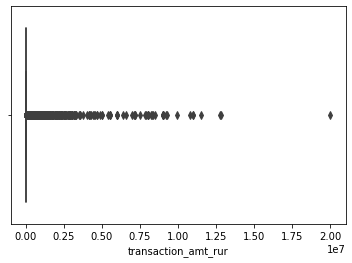

In [142]:
sns.boxplot(x=df_train['transaction_amt_rur']);

In [147]:
df_train_out,_,_ = removing_outliers('transaction_amt_rur',df_train)

Количество строк, выбранных для удаления transaction_amt_rur: 3250777. Количество итераций 5



In [32]:
# Q1 = df_train['transaction_amt_rur'].quantile(0.25)
# Q3 = df_train['transaction_amt_rur'].quantile(0.75)
# IQR = Q3 - Q1
# df_train_out = df_train[~((df_train['transaction_amt_rur'] < (Q1 - 1.5 * IQR)) | (df_train['transaction_amt_rur'] > (Q3 + 1.5 * IQR)))]

In [131]:
# Q1_out = df_train_out['transaction_amt_rur'].quantile(0.25)
# Q3_out = df_train_out['transaction_amt_rur'].quantile(0.75)
# IQRout = Q3_out - Q1_out
# df_train_out[((df_train_out['transaction_amt_rur'] < (Q1_out - 1.5 * IQRout)) | (df_train_out['transaction_amt_rur'] > (Q3_out + 1.5 * IQRout)))]

,party_rk,financial_account_type_cd,transaction_dttm,transaction_amt_rur,category
9,26389,2,2019-01-01,1734.00,Красота
12,56812,2,2019-01-01,1695.00,Разные товары
41,48118,2,2019-01-01,1825.62,Супермаркеты
53,52526,1,2019-01-01,2097.30,Супермаркеты
61,10843,2,2019-01-01,1535.38,Сервисные услуги
...,...,...,...,...,...
11987514,36547,2,2019-12-31,1594.20,Аптеки
11987531,60666,2,2019-12-31,1575.37,Супермаркеты
11987547,58193,2,2019-12-31,2023.00,Одежда/Обувь
11987556,35566,1,2019-12-31,2346.00,Супермаркеты


In [144]:
print('Количество строк до удаления выбросов: {}, количество столбцов: {}'.format(df_train.shape[0], df_train.shape[1]))
print('Количество строк после удаления выбросов: {}, количество столбцов: {}'.format(df_train_out.shape[0], df_train_out.shape[1]))

Количество строк до удаления выбросов: 11987617, количество столбцов: 5
Количество строк после удаления выбросов: 8434344, количество столбцов: 5


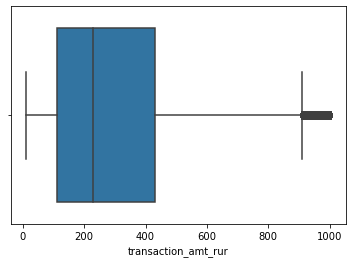

In [148]:
sns.boxplot(x=df_train_out['transaction_amt_rur']);

##### Заполнение пропусков <a class="anchor" id="ch2213"></a>

In [149]:
print("\nКоличество пропущенных значений до заполнения пропусков:")
df_train_out.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений до заполнения пропусков:


,category,party_rk,financial_account_type_cd,transaction_dttm,transaction_amt_rur
0,902694,0,0,0,0


Для заполнения пропусков числовых переменных используются несколько методов, но мы будем использовать самый простой: в случае числового признака заменяем на среднее значение по столбцу (тк мы ранее удалили выбросы, то это среднее будет не смещенное), если это категориальный признак, то заменяем на моду. 

In [150]:
df_train_out['transaction_amt_rur'] = df_train_out['transaction_amt_rur'].fillna(df_train_out['transaction_amt_rur'].mean())

In [151]:
df_train_out['category'] = df_train_out['category'].fillna(df_train_out['category'].mode()[0])

In [152]:
print("\nКоличество пропущенных значений после заполнения пропусков:")
df_train_out.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений после заполнения пропусков:


,party_rk,financial_account_type_cd,transaction_dttm,transaction_amt_rur,category
0,0,0,0,0,0


##### Приведение категориальных признаков к числовому виду <a class="anchor" id="ch2212"></a>

Модели, которые мы будем в дальнейшем применять, работают только с числовыми признаками, поэтому приведем категориальные признаки к числовым. В основном различают 2 способа: One-hot Encoding и LabelEncoder. Второй применятся в том случае, когда мы можем выявить в данных определенный порядок, в нашем случае в столбце category ранжировать мы не можем, поэтому будем использовать One-hot Encoding.

In [153]:
# функция для перевода категориального признака в числовой через One-hot Encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [154]:
df_train_out_num = encode_and_bind(df_train_out, 'category')

In [155]:
del df_train_out_num['category']

In [156]:
df_train_out_num

,party_rk,financial_account_type_cd,transaction_dttm,transaction_amt_rur,category_Duty Free,category_Авиабилеты,category_Автоуслуги,category_Аптеки,category_Аренда авто,category_Госсборы,...,category_Сувениры,category_Супермаркеты,category_Топливо,category_Транспорт,category_Турагентства,category_Фаст Фуд,category_Финансовые услуги,category_Фото/Видео,category_Цветы,category_Частные услуги
0,20337,1,2019-01-01,84.00,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,63404,1,2019-01-01,410.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,24789,2,2019-01-01,701.44,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,12232,2,2019-01-01,734.53,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,51074,2,2019-01-01,366.60,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11987612,44990,1,2019-12-31,121.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11987613,53023,2,2019-12-31,102.29,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11987614,78716,1,2019-12-31,175.00,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11987615,73104,2,2019-12-31,185.99,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### df_socdem <a class="anchor" id="ch222"></a>

В данной таблице содержится персональная информация клиентов, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>gender_cd</strong> - пол клиента (F - женщина / M - мужчина / не указан)</li>
<li><strong>age</strong> - возраст клиента</li>
<li><strong>marital_status_desc</strong> - семейное положение (один из 7 вариантов: Женат/замужем / Вдовец, вдова / Холост/не замужем / Гражданский брак / Разведен (а) / Не проживает с супругом (ой) / Не указано)</li>
<li><strong>children_cnt</strong> - количество детей</li>
<li><strong>region_flg</strong> - бинарная характеристика региона клиента</li>
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут party_rk.

In [157]:
df_socdem.head()

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,F,70.0,NaN,0,0
1,66535,F,25.0,NaN,0,0
2,83721,M,55.0,Женат/замужем,0,0
3,88238,F,35.0,NaN,0,0
4,57179,F,30.0,Женат/замужем,0,0


##### Первичный анализ <a class="anchor" id="ch2221"></a>

In [158]:
print('Количество строк: {}, количество столбцов: {}'.format(df_socdem.shape[0], df_socdem.shape[1]))

Количество строк: 50000, количество столбцов: 6


Проверим на всякий случай, что у нас party_rk это первичный ключ. 

In [159]:
print('Количество уникальных значений party_rk: {}'.format(len(df_socdem['party_rk'].unique())))

Количество уникальных значений party_rk: 50000


In [160]:
df_socdem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   party_rk             50000 non-null  int64  
 1   gender_cd            49989 non-null  object 
 2   age                  50000 non-null  float64
 3   marital_status_desc  37594 non-null  object 
 4   children_cnt         50000 non-null  int64  
 5   region_flg           50000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.3+ MB


In [161]:
df_socdem.describe()

,party_rk,age,children_cnt,region_flg
count,50000.00000,50000.000000,50000.000000,50000.000000
mean,47339.73202,39.062300,0.388660,0.091900
std,27317.74524,11.675057,0.968928,0.288888
min,1.00000,15.000000,0.000000,0.000000
25%,23669.75000,30.000000,0.000000,0.000000
50%,47434.50000,35.000000,0.000000,0.000000
75%,70961.50000,45.000000,0.000000,0.000000
max,94610.00000,100.000000,4.000000,1.000000


Заметим, что максимальное значение возраста может достигать значения 100, так что, вероятно, это может быть выбросом. Проверим это в разделе "Удаление выбросов". 

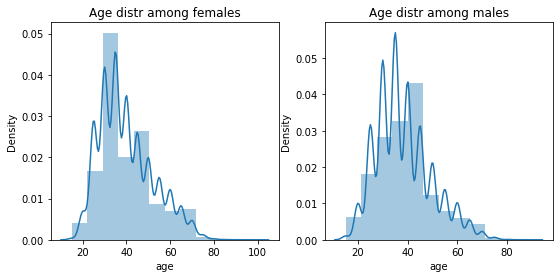

In [162]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

female = df_socdem[df_socdem['gender_cd'] == 'F']
male = df_socdem[df_socdem['gender_cd'] == 'M']

sns.distplot(female['age'], bins=12 ,ax=ax1)
sns.distplot(male['age'], bins=12, ax=ax2)

ax1.set_title('Age distr among females');
ax2.set_title('Age distr among males');

По графику можно сделать вывод, что возраст мужчин в среднем больше, чем возраст женщин. 

Добавим категориальный признак AgeGroup, позволяющий разделить всех клиентов на 6 групп в соответствии с их возрастом:

In [163]:
df_socdem.loc[(df_socdem.age < 21),  'AgeGroup'] = '0-21'
df_socdem.loc[(21 <= df_socdem.age),  'AgeGroup'] = '21-29'
df_socdem.loc[(30 <= df_socdem.age),  'AgeGroup'] = '30-40'
df_socdem.loc[(41 <= df_socdem.age),  'AgeGroup'] = '41-54'
df_socdem.loc[(54 <= df_socdem.age),  'AgeGroup'] = '55-65'
df_socdem.loc[(65 <= df_socdem.age),  'AgeGroup'] = '65+'

In [164]:
df_socdem

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg,AgeGroup
0,61243,F,70.0,NaN,0,0,65+
1,66535,F,25.0,NaN,0,0,21-29
2,83721,M,55.0,Женат/замужем,0,0,55-65
3,88238,F,35.0,NaN,0,0,30-40
4,57179,F,30.0,Женат/замужем,0,0,30-40
...,...,...,...,...,...,...,...
49995,54994,M,40.0,Женат/замужем,0,0,30-40
49996,63391,M,35.0,Холост/не замужем,0,0,30-40
49997,5418,F,55.0,Холост/не замужем,0,0,55-65
49998,50273,F,35.0,Женат/замужем,0,0,30-40


In [165]:
# удалим ненужный столбец
del df_socdem['age']

##### Заполнение пропусков <a class="anchor" id="ch2223"></a>

In [166]:
print("\nКоличество пропущенных значений до заполнения пропусков:")
df_socdem.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений до заполнения пропусков:


,marital_status_desc,gender_cd,party_rk,children_cnt,region_flg,AgeGroup
0,12406,11,0,0,0,0


Вместо пропущенных значений в колонках 'marital_status_desc' и 'gender_cd' запишем значение unknown, что будет означать, что пользователь не указала своего статуса или пола. 

In [167]:
df_socdem['gender_cd'] = df_socdem['gender_cd'].fillna('unknown')
df_socdem['marital_status_desc'] = df_socdem['marital_status_desc'].fillna('unknown')

In [168]:
print("\nКоличество пропущенных значений после заполнения пропусков:")
df_socdem.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений после заполнения пропусков:


,party_rk,gender_cd,marital_status_desc,children_cnt,region_flg,AgeGroup
0,0,0,0,0,0,0


##### Приведение категориальных признаков к числовому виду <a class="anchor" id="ch2222"></a>

Заменим признак AgeGroup на числовые значения с помощью LabelEncoder, так как внутри этого признака сожно выявить порядок. 

In [169]:
# AgeGroup - категориальный признак, переведем его в тип int
le_age = preprocessing.LabelEncoder()
le_age.fit(df_socdem['AgeGroup'])
df_socdem['AgeGroup'] = le_age.transform(df_socdem['AgeGroup'])

Остальные колонки 'gender_cd' и 'material_status_desc' заменим при помощи One-hot Encoding. 

In [170]:
df_socdem_num = encode_and_bind(df_socdem, 'gender_cd')
df_socdem_num_ = encode_and_bind(df_socdem_num, 'marital_status_desc')

In [171]:
del df_socdem_num_['marital_status_desc']
del df_socdem_num_['gender_cd']

In [172]:
df_socdem_num_.head()

,party_rk,children_cnt,region_flg,AgeGroup,gender_cd_F,gender_cd_M,gender_cd_unknown,marital_status_desc_unknown,"marital_status_desc_Вдовец, вдова",marital_status_desc_Гражданский брак,marital_status_desc_Женат/замужем,marital_status_desc_Не проживает с супругом (ой),marital_status_desc_Разведен (а),marital_status_desc_Холост/не замужем
0,61243,0,0,5,1,0,0,1,0,0,0,0,0,0
1,66535,0,0,1,1,0,0,1,0,0,0,0,0,0
2,83721,0,0,4,0,1,0,0,0,0,1,0,0,0
3,88238,0,0,2,1,0,0,1,0,0,0,0,0,0
4,57179,0,0,2,1,0,0,0,0,0,1,0,0,0


### df_balance <a class="anchor" id="ch223"></a>

В данной таблице содержится ежемесячная информация о изменениях баланса клиентов, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>account_rk</strong> - уникальный идентификационный номер счета</li>
<li><strong>prev_month</strong> - дата последнего дня (t-1)-го месяца в формате ГГГГ-ММ-ДД</li>
<li><strong>cur_month</strong> - дата последнего дня t-го месяца в формате ГГГГ-ММ-ДД</li>
<li><strong>balance_chng</strong> - изменение баланса в течение периода времени [prev_month, cur_month]</li>
</ul>
<strong>Первичный ключ</strong> таблицы является составным из двух атрибутов: account_rk + prev_month.

In [187]:
df_balance.head()

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0


##### Первичный анализ <a class="anchor" id="ch2231"></a>

In [188]:
print('Количество строк: {}, количество столбцов: {}'.format(df_balance.shape[0], df_balance.shape[1]))

Количество строк: 614434, количество столбцов: 5


In [189]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614434 entries, 0 to 614433
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   party_rk      614434 non-null  int64  
 1   account_rk    614434 non-null  int64  
 2   prev_month    612832 non-null  object 
 3   cur_month     612832 non-null  object 
 4   balance_chng  612832 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 23.4+ MB


Переведем признаки 'prev_month' и 'cur_month' в тип datetime.

In [190]:
df_balance['prev_month'] = pd.to_datetime(df_balance['prev_month'])
df_balance['cur_month'] = pd.to_datetime(df_balance['cur_month'])

In [191]:
df_balance

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0
...,...,...,...,...,...
614429,13734,124222,NaT,NaT,NaN
614430,33502,125615,NaT,NaT,NaN
614431,8735,123871,NaT,NaT,NaN
614432,91302,122557,NaT,NaT,NaN


##### Заполнение пропусков <a class="anchor" id="ch2233"></a>

In [192]:
print("\nКоличество пропущенных значений до заполнения пропусков:")
df_balance.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений до заполнения пропусков:


,prev_month,cur_month,balance_chng,party_rk,account_rk
0,1602,1602,1602,0,0


В тех строчках, где у нас пропущенные значения 'prev_month' и 'cur_month', нет смысла вставлять туда  моду, так как мы работаем с датами.

In [193]:
df_balance = df_balance.dropna(subset=["prev_month"],axis =0)
df_balance = df_balance.dropna(subset=["cur_month"],axis = 0)

In [194]:
print("\nКоличество пропущенных значений до заполнения пропусков:")
df_balance.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений до заполнения пропусков:


,party_rk,account_rk,prev_month,cur_month,balance_chng
0,0,0,0,0,0


##### Удаление выбросов <a class="anchor" id="ch2233"></a>

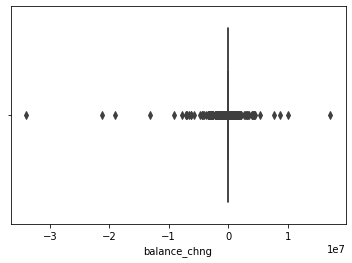

In [195]:
sns.boxplot(x=df_balance['balance_chng']);

In [196]:
df_balance['pos_change'] = df_balance['balance_chng'].apply(lambda x: x if x >= 0 else x * -1)
df_balance_out,_,_ = removing_outliers('pos_change',df_balance)
df_balance_out=df_balance_out.drop(['pos_change'],axis = 1)
df_balance=df_balance.drop(['pos_change'],axis = 1)

Количество строк, выбранных для удаления pos_change: 129475. Количество итераций 3



In [197]:
# Q1 = df_balance['balance_chng'].quantile(0.25)
# Q3 = df_balance['balance_chng'].quantile(0.75)
# IQR = Q3 - Q1
# df_balance_out = df_balance[~((df_balance['balance_chng'] < (Q1 - 1.5 * IQR)) | (df_balance['balance_chng'] > (Q3 + 1.5 * IQR)))]

In [198]:
print('Количество строк до удаления выбросов: {}, количество столбцов: {}'.format(df_balance.shape[0], df_balance.shape[1]))
print('Количество строк после удаления выбросов: {}, количество столбцов: {}'.format(df_balance_out.shape[0], df_balance_out.shape[1]))

Количество строк до удаления выбросов: 612832, количество столбцов: 5
Количество строк после удаления выбросов: 483357, количество столбцов: 5


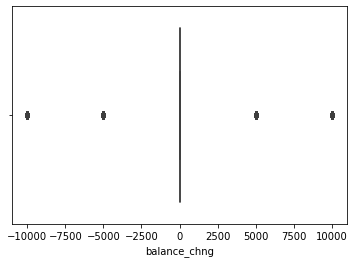

In [199]:
sns.boxplot(x=df_balance_out['balance_chng']);

In [200]:
df_balance_out.head()

,party_rk,account_rk,prev_month,cur_month,balance_chng
1,59074,70471,2018-12-31,2019-01-31,0.0
5,46840,48834,2018-12-31,2019-01-31,-5000.0
6,51748,52590,2018-12-31,2019-01-31,0.0
7,11781,8193,2018-12-31,2019-01-31,-10000.0
8,4489,3769,2018-12-31,2019-01-31,0.0


### df_stories_texts <a class="anchor" id="ch224"></a>

В данной таблице содержится информация об историях, выкладываемых Тинькоффом, где
<ul>
<li><strong>story_id</strong> - уникальный идентификационный номер истории</li> 
<li><strong>name</strong> - заголовок истории</li>
<li><strong>story_text</strong> - текст истории</li>
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут story_id.

In [201]:
df_story_texts.head()

,story_id,name,story_text
0,794,Профессия: свадебный организатор,"["""",""Как стать свадебным организатором"",""Это Л..."
1,821,Бизнес: магазин электроники,"["""",""Как открыть интернет-магазин электроники""..."
2,824,Как у них: Сингапур,"["""",""Жизнь в Сингапуре"",""Это Славина. Вместе с..."
3,839,Студии йоги,"["""",""Студии йоги"",""7 московских студий, где мо..."
4,848,Как получать больше кэшбэка,"["""",""Как получать больше кэшбэка"",""Подключите ..."


##### Первичный анализ <a class="anchor" id="ch2241"></a>

In [202]:
print('Количество строк: {}, количество столбцов: {}'.format(df_story_texts.shape[0], df_story_texts.shape[1]))

Количество строк: 1631, количество столбцов: 3


In [203]:
df_story_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   story_id    1631 non-null   int64 
 1   name        1401 non-null   object
 2   story_text  1631 non-null   object
dtypes: int64(1), object(2)
memory usage: 38.4+ KB


##### Заполнение пропусков <a class="anchor" id="ch2243"></a>

In [204]:
print("\nКоличество пропущенных значений:")
df_story_texts.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,name,story_id,story_text
0,230,0,0


In [205]:
df_story_texts['name'] = df_story_texts['name'].fillna('Unknown')

In [206]:
print("\nКоличество пропущенных значений:")
df_story_texts.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,story_id,name,story_text
0,0,0,0


In [207]:
print('Всего топиков стори: {}'.format(df_story_texts['name'].nunique()))

Всего топиков стори: 1106


### df_stories_logs <a class="anchor" id="ch225"></a>

В данной таблице содержится информация о действиях клиентов относительно историй, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>date_time</strong> - дата и время действия клиента в формате ГГГГ-ММ-ДД ЧЧ:ММ:СС </li>
<li><strong>story_id</strong> - уникальный идентификационный номер истории</li>
<li><strong>category</strong> - уникальный идентификационный номер категории действия</li>
<li><strong>event</strong> - наименование действия (like / dislike / ...)</li>
</ul>
<strong>Первичный ключ</strong> таблицы является составным из двух атрибутов: party_rk + date_time.

In [208]:
df_stories_logs.head()

,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,like
1,55721,2019-12-01 13:18:08,3857,39,like
2,27563,2019-12-01 13:25:40,3174,78,like
3,61223,2019-12-01 13:25:20,3857,39,like
4,61223,2019-12-01 13:29:05,3765,73,like


##### Первичный анализ <a class="anchor" id="ch2251"></a>

In [209]:
print('Количество строк: {}, количество столбцов: {}'.format(df_stories_logs.shape[0], df_stories_logs.shape[1]))

Количество строк: 13820, количество столбцов: 5


In [210]:
df_stories_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13820 entries, 0 to 13819
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   party_rk   13820 non-null  int64 
 1   date_time  13820 non-null  object
 2   story_id   13820 non-null  int64 
 3   category   13820 non-null  int64 
 4   event      13820 non-null  object
dtypes: int64(3), object(2)
memory usage: 540.0+ KB


Заметим, что у признака 'date_time', который представляет из себя дату, тип object, хотя должен быть тип datetime.

In [211]:
df_stories_logs['date_time'] = pd.to_datetime(df_stories_logs['date_time'])

In [212]:
df_stories_logs['event'].value_counts().reset_index()

,index,event
0,like,5920
1,favorite,5028
2,dislike,763
3,14],592
4,77],551
5,153,208
6,180,108
7,177,99
8,176,72
9,54],54


Удалим строки с непонятными (числовыми) значениями по признаку 'index' 

In [213]:
df_stories_logs = df_stories_logs[(df_stories_logs['event'] == 'like') | (df_stories_logs['event'] =='dislike') | (df_stories_logs['event'] =='favorite')] 

In [214]:
df_stories_logs.head()

,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,like
1,55721,2019-12-01 13:18:08,3857,39,like
2,27563,2019-12-01 13:25:40,3174,78,like
3,61223,2019-12-01 13:25:20,3857,39,like
4,61223,2019-12-01 13:29:05,3765,73,like


##### Приведение категориальных признаков к числовому виду <a class="anchor" id="ch2252"></a>

In [215]:
# заменим в стобце event категориальные значение на числа
df_stories_logs['event_cat'] = np.where(df_stories_logs['event'] == 'dislike' , 0, df_stories_logs['event'])
df_stories_logs['event_cat'] = np.where(df_stories_logs['event'] == 'like' , 1, df_stories_logs['event_cat'])
df_stories_logs['event_cat'] = np.where(df_stories_logs['event'] == 'favorite' , 2, df_stories_logs['event_cat'])

In [216]:
df_stories_logs.head()

,party_rk,date_time,story_id,category,event,event_cat
0,64266,2019-12-01 13:05:31,3840,39,like,1
1,55721,2019-12-01 13:18:08,3857,39,like,1
2,27563,2019-12-01 13:25:40,3174,78,like,1
3,61223,2019-12-01 13:25:20,3857,39,like,1
4,61223,2019-12-01 13:29:05,3765,73,like,1


In [217]:
del df_stories_logs['event']

##### Заполнение пропусков <a class="anchor" id="ch2253"></a>

In [218]:
print("\nКоличество пропущенных значений:")
df_stories_logs.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,party_rk,date_time,story_id,category,event_cat
0,0,0,0,0,0


### df_products <a class="anchor" id="ch226"></a>

В данной таблице содержится информация о связи пользователей с некоторыми категориями продуктов, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>product1 - ... - product7</strong> - связи пользователя и соответствующего продукта </li>
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут party_rk.

In [219]:
df_products.head()

,party_rk,product1,product2,product3,product4,product5,product6,product7
0,74874,1,1,0,0,0,0,0
1,83618,0,0,1,1,1,0,0
2,73766,0,0,0,1,1,0,0
3,60218,0,1,0,0,0,0,0
4,47253,0,0,0,1,1,0,0


##### Первичный анализ <a class="anchor" id="ch2261"></a>

In [220]:
print('Количество строк: {}, количество столбцов: {}'.format(df_products.shape[0], df_products.shape[1]))

Количество строк: 50000, количество столбцов: 8


In [221]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   party_rk  50000 non-null  int64
 1   product1  50000 non-null  int64
 2   product2  50000 non-null  int64
 3   product3  50000 non-null  int64
 4   product4  50000 non-null  int64
 5   product5  50000 non-null  int64
 6   product6  50000 non-null  int64
 7   product7  50000 non-null  int64
dtypes: int64(8)
memory usage: 3.1 MB


Проверим, являются ли значения во всех столбцах бинарными. 

In [239]:
columns_products = df_products.columns[1:]
for column in columns_products:
    print('Столбец: ',column)
    print(df_products[column].value_counts(),end='\n\n')

Столбец:  product1
0    42582
1     7418
Name: product1, dtype: int64

Столбец:  product2
1    30983
0    19017
Name: product2, dtype: int64

Столбец:  product3
0    42625
1     7375
Name: product3, dtype: int64

Столбец:  product4
1    32560
0    17440
Name: product4, dtype: int64

Столбец:  product5
1    29704
0    20296
Name: product5, dtype: int64

Столбец:  product6
0    47348
1     2652
Name: product6, dtype: int64

Столбец:  product7
0    42280
1     7720
Name: product7, dtype: int64



Да, все признаки являются бинарными. 

##### Заполнение пропусков <a class="anchor" id="ch2263"></a>

In [240]:
print("\nКоличество пропущенных значений:")
df_products.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,party_rk,product1,product2,product3,product4,product5,product6,product7
0,0,0,0,0,0,0,0,0


## Визуализация данных  <a class="anchor" id="ch4"></a>

In [241]:
df_cluster = pd.merge(df_train, df_socdem)

In [242]:
df_category_trans = df_cluster.groupby("category")['transaction_amt_rur'].sum().reset_index().sort_values(by = 'transaction_amt_rur', ascending = False)

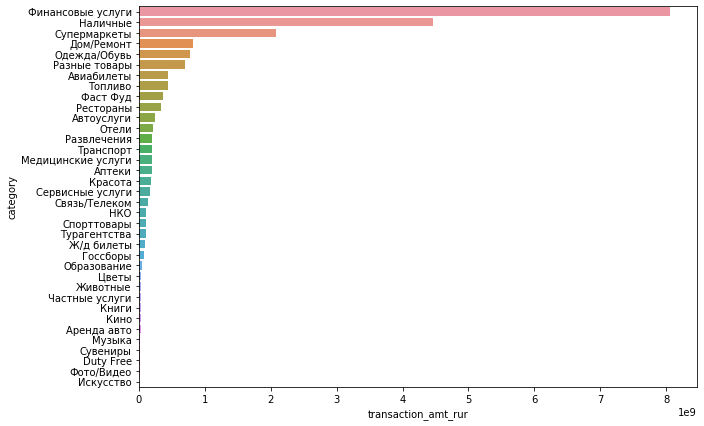

In [243]:
plt.figure(figsize=(10,7))
sns.barplot(x="transaction_amt_rur", y="category", data=df_category_trans, orient = 'h');

In [104]:
## ИСПРАВИИИИИИТЬЬЬЬЬЬЬ
# df_distr = pd.pivot_table(data = df_cluster[['age', 'transaction_amt_rur', 'children_cnt', 'gender_cd', 'category']], index = ['gender_cd', 'category'])

In [105]:
# df_distr = df_distr.reset_index()

In [106]:
# plt.figure(figsize=(16,10))
# sns.lineplot(data= df_distr, x=df_distr['category'], y=df_distr['transaction_amt_rur'], hue=df_distr['gender_cd'])
# plt.xticks(rotation=90);

## Feature Engineering  <a class="anchor" id="ch9"></a>

Создадим <strong> новые признаки </strong> для единой итоговой таблицы, характеризующие совершаемые клиентами транзакции в различных категориях. Новые характеристики будут отражать  
<ul>
    <li>средние траты по категориям,</li>
    <li>частоту покупок (в т.ч. повторных покупок в одной категории), </li>
    <li>статистику активности клиентов в интернете по данным категориям товаров и т.д.</li>
</ul>

### Признак №1 <a class="anchor" id="ch91"></a>

<strong>Признак:</strong> рейтинг категорий, которые лайкнул пользователь. Для того, чтобы его посчитать, смотрим на то, сколько лайков юзер поставил на стори той или иной категории и делим это на суммарное количество лайков по всем категориям. 

$\frac{\mbox{(Количество лайков у человека в конкретной категории в данном месяце)}}{\mbox{(Общее количество лайков человека в конкретном месяце)}}$

In [244]:
df_stories_logs

,party_rk,date_time,story_id,category,event_cat
0,64266,2019-12-01 13:05:31,3840,39,1
1,55721,2019-12-01 13:18:08,3857,39,1
2,27563,2019-12-01 13:25:40,3174,78,1
3,61223,2019-12-01 13:25:20,3857,39,1
4,61223,2019-12-01 13:29:05,3765,73,1
...,...,...,...,...,...
13815,19043,2019-12-31 22:52:40,4117,71,1
13816,19043,2019-12-31 22:53:13,4120,39,1
13817,10195,2019-12-31 23:32:50,4117,71,2
13818,10195,2019-12-31 23:33:32,4120,39,1


In [245]:
# создадим таблицу, с количеством лайков каждого пользователя в конкректной категории
party_ids = []

for i in df_socdem_num_['party_rk'].unique():
    for j in range(55):
        party_ids.append(i)
        
a_likes = list(df_stories_logs['category'].unique()) * 50000
temple_likes = pd.DataFrame({'party_rk': party_ids, 'category': a_likes})
df_stories_logs['Month'] = pd.DatetimeIndex(df_stories_logs['date_time']).month
df_stories_logs_likes = df_stories_logs[((df_stories_logs['Month'] == 10) | (df_stories_logs['Month'] == 11)) &
                                   (df_stories_logs['event_cat'] == 1)]
df_stories_logs_new_likes = df_stories_logs_likes.copy()
del df_stories_logs_new_likes['date_time']
del df_stories_logs_new_likes['story_id']
del df_stories_logs_new_likes['Month']
df_cat_likes = pd.DataFrame(df_stories_logs_new_likes.groupby(["party_rk", "category"])['event_cat'].count())
df_cat_likes.columns = ['number_likes']
df_cat_likes.reset_index(inplace = True)
df_cat_likes_1 = pd.merge(temple_likes, df_cat_likes, how='left')
df_cat_likes_1['number_likes'] = df_cat_likes_1['number_likes'].fillna(0)
df_cat_likes_1

,party_rk,category,number_likes
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [246]:
# создадим таблицу с суммарным количеством лайков по каждому пользователю
df_cat_likes_likes_all_cat = df_cat_likes_1[['party_rk', 'number_likes']]
df_cat_likes_likes_all_cat.columns = ['party_rk', 'sum_number_likes']
df_cat_likes_likes_all_cat = df_cat_likes_likes_all_cat.groupby(['party_rk'])['sum_number_likes'].agg('sum').reset_index()
df_cat_likes_likes_all_cat

,party_rk,sum_number_likes
0,1,0.0
1,5,0.0
2,7,0.0
3,8,0.0
4,9,0.0
...,...,...
49995,94603,0.0
49996,94606,0.0
49997,94607,0.0
49998,94608,0.0


In [247]:
# создадим таблицу, где будет храниться информация о частоте лайков для каждого пользователя и категории
df_temp1_likes = pd.merge(df_cat_likes_1, df_cat_likes_likes_all_cat, how = 'left')
df_temp1_likes['freq_likes'] = 1.0 * df_temp1_likes['number_likes']/df_temp1_likes['sum_number_likes']
df_temp1_likes = df_temp1_likes[['party_rk', 'category', 'freq_likes']]
df_temp1_likes.fillna(0, inplace = True)
df_temp1_likes

,party_rk,category,freq_likes
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [248]:
df_new_likes = pd.DataFrame({'party_rk': df_socdem_num_['party_rk'].unique()})
for i in df_stories_logs['category'].unique():
    df_temp_for_likes = df_temp1_likes[df_temp1_likes['category'] == i]
    del df_temp_for_likes['category']
    df_new_likes_ = pd.merge(df_new_likes, df_temp_for_likes, left_on = 'party_rk', right_on = 'party_rk', how = 'left')
    df_new_likes = df_new_likes_.copy()

In [249]:
df_new_likes 

,party_rk,freq_likes_x,freq_likes_y,freq_likes_x,freq_likes_y,freq_likes_x,freq_likes_y,freq_likes_x,freq_likes_y,freq_likes_x,...,freq_likes_y,freq_likes_x,freq_likes_y,freq_likes_x,freq_likes_y,freq_likes_x,freq_likes_y,freq_likes_x,freq_likes_y,freq_likes
0,61243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,54994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,63391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,5418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,50273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [250]:
s_likes = ['party_rk']
for i in df_stories_logs['category'].unique():
    string_name = 'feature1_' + str(i) 
    s_likes.append(string_name)
df_new_likes.columns = s_likes
df_new_likes_final = df_new_likes.copy()

In [251]:
df_new_likes_final

,party_rk,feature1_39,feature1_78,feature1_73,feature1_81,feature1_44,feature1_16,feature1_68,feature1_15,feature1_71,...,feature1_17,feature1_72,feature1_42,feature1_1,feature1_23,feature1_21,feature1_64,feature1_77,feature1_79,feature1_75
0,61243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,54994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,63391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,5418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,50273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Признак №2 <a class="anchor" id="ch92"></a>

<strong>Признак:</strong> рейтинг категорий, которые дизлайкнул пользователь. Для того, чтобы его посчитать, смотрим на то, сколько дизлайков юзер поставил на стори той или иной категории и делим это на суммарное количество дизлайков по всем категориям. 

$\frac{\mbox{(Количество дизлайков у человека в конкретной категории в данном месяце)}}{\mbox{(Общее количество дизлайков человека в конкретном месяце)}}$

In [252]:
# создадим таблицу, с количеством дизлайков каждого пользователя в конкректной категории
a_dislikes = list(df_stories_logs['category'].unique()) * 50000
temple_dislikes = pd.DataFrame({'party_rk': party_ids, 'category': a_likes})
df_stories_logs['Month'] = pd.DatetimeIndex(df_stories_logs['date_time']).month
df_stories_logs_dislikes = df_stories_logs[((df_stories_logs['Month'] == 10) | (df_stories_logs['Month'] == 11)) &
                                   (df_stories_logs['event_cat'] == 0)]
df_stories_logs_new_dislikes = df_stories_logs_dislikes.copy()
del df_stories_logs_new_dislikes['date_time']
del df_stories_logs_new_dislikes['story_id']
del df_stories_logs_new_dislikes['Month']
df_cat_dislikes = pd.DataFrame(df_stories_logs_new_dislikes.groupby(["party_rk", "category"])['event_cat'].count())
df_cat_dislikes.columns = ['number_dislikes']
df_cat_dislikes.reset_index(inplace = True)
df_cat_dislikes_1 = pd.merge(temple_dislikes, df_cat_dislikes, how='left')
df_cat_dislikes_1['number_dislikes'] = df_cat_dislikes_1['number_dislikes'].fillna(0)
df_cat_dislikes_1

,party_rk,category,number_dislikes
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [253]:
# создадим таблицу с суммарным количеством дизлайков по каждому пользователю
df_cat_dislikes_dislikes_all_cat = df_cat_dislikes_1[['party_rk', 'number_dislikes']]
df_cat_dislikes_dislikes_all_cat.columns = ['party_rk', 'sum_number_dislikes']
df_cat_dislikes_dislikes_all_cat = df_cat_dislikes_dislikes_all_cat.groupby(['party_rk'])['sum_number_dislikes'].agg('sum').reset_index()
df_cat_dislikes_dislikes_all_cat

,party_rk,sum_number_dislikes
0,1,0.0
1,5,0.0
2,7,0.0
3,8,0.0
4,9,0.0
...,...,...
49995,94603,0.0
49996,94606,0.0
49997,94607,0.0
49998,94608,0.0


In [254]:
# создадим таблицу, где будет храниться информация о частоте лайков для каждого пользователя и категории
df_temp1_dislikes = pd.merge(df_cat_dislikes_1, df_cat_dislikes_dislikes_all_cat, how = 'left')
df_temp1_dislikes['freq_dislikes'] = 1.0 * df_temp1_dislikes['number_dislikes']/df_temp1_dislikes['sum_number_dislikes']
df_temp1_dislikes = df_temp1_dislikes[['party_rk', 'category', 'freq_dislikes']]
df_temp1_dislikes.fillna(0, inplace = True)
df_temp1_dislikes

,party_rk,category,freq_dislikes
0,61243,39,0.0
1,61243,78,0.0
2,61243,73,0.0
3,61243,81,0.0
4,61243,44,0.0
...,...,...,...
2749995,77268,21,0.0
2749996,77268,64,0.0
2749997,77268,77,0.0
2749998,77268,79,0.0


In [255]:
df_new_dislikes = pd.DataFrame({'party_rk': df_socdem_num_['party_rk'].unique()})
for i in df_stories_logs['category'].unique():
    df_temp_for_dislikes = df_temp1_dislikes[df_temp1_dislikes['category'] == i]
    del df_temp_for_dislikes['category']
    df_new_dislikes_ = pd.merge(df_new_dislikes, df_temp_for_dislikes, left_on = 'party_rk', right_on = 'party_rk', how = 'left')
    df_new_dislikes = df_new_dislikes_.copy()

In [256]:
s_dislikes = ['party_rk']
for i in df_stories_logs['category'].unique():
    string_name = 'feature2_' + str(i) 
    s_dislikes.append(string_name)
df_new_dislikes.columns = s_dislikes
df_new_dislikes_final = df_new_dislikes.copy()

In [257]:
df_new_dislikes_final.head()

,party_rk,feature2_39,feature2_78,feature2_73,feature2_81,feature2_44,feature2_16,feature2_68,feature2_15,feature2_71,...,feature2_17,feature2_72,feature2_42,feature2_1,feature2_23,feature2_21,feature2_64,feature2_77,feature2_79,feature2_75
0,61243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Признак №3 <a class="anchor" id="ch93"></a>

### Признак №4 <a class="anchor" id="ch94"></a>

<strong>Признак:</strong> средняя сумма в месяц, потраченная пользователем на конкретную категорию (подсчет по последним трем месяцам).

Получим 37 новых столбцов для единой итоговой таблицы.

Укажем даты начала и конца периода из крайних трех месяцев тренировочной выборки:

In [258]:
date1 = datetime.datetime(2019,11,30)
date4 = datetime.datetime(2019,8,31)

In [259]:
# Функция для вывода транзакций в указанном периоде
def cutDate(start_date, stop_date):
    v1_1 = df_train_out[df_train_out['transaction_dttm'] <= stop_date]
    pre_cut = v1_1[start_date < v1_1['transaction_dttm']]
    final_cut = pre_cut['party_rk'].to_frame()
    return pre_cut, final_cut

In [260]:
# Выпишем все party_rk всех пользователей
df_pr4 = df_socdem_num['party_rk'].to_frame()

# Выведем все транзакции, совершаемые в периоде времени [date4, date1]
month_3_pre_cut, month_3_final_cut  = cutDate(date4, date1)
month_3_pre_cut

,party_rk,financial_account_type_cd,transaction_dttm,transaction_amt_rur,category
4668483,28040,1,2019-09-01,317.0,Супермаркеты
4668488,80499,1,2019-09-01,261.0,Транспорт
4668489,9875,2,2019-09-01,520.0,Супермаркеты
4668490,57689,2,2019-09-01,333.4,Финансовые услуги
4668492,18497,1,2019-09-01,75.9,Супермаркеты
...,...,...,...,...,...
11715156,54538,2,2019-11-30,312.0,Транспорт
11724649,26838,2,2019-11-30,130.0,Супермаркеты
11724650,86369,2,2019-11-30,172.0,Супермаркеты
11724651,2080,1,2019-11-30,472.6,Разные товары


In [261]:
# Пройдем по каждой из 37 категорий и посчитаем среднюю сумму трат, сгруппированных по пользователям, 
# а затем занесем новый получившийся столбец в общую таблицу df_pr4

res4 = pd.DataFrame()
for i in range(37):
    v4_1 = month_3_pre_cut[month_3_pre_cut['category'] == i]
    v4_2 = v4_1[['party_rk', 'transaction_amt_rur']]
    feature4 = v4_2.groupby(['party_rk']).mean()
    name2 = 'feature_4_' + str(i)
    feature4 = feature4.rename(columns={'transaction_amt_rur': name2}) 
    df_pr4 = pd.merge(df_pr4, feature4, left_on='party_rk', right_on='party_rk', how='left') 

In [262]:
# Заполним нулями все поля для пользователей, которые ничего не покупали в рассматриваемой категории за данные 3 месяца
final_feature4 = df_pr4.fillna(0)

Получаем таблицу, 37-ью столбцами которой являются категории покупок, строками - пользователи, а на перечении стоит искомый признак:

In [263]:
final_feature4

,party_rk,feature_4_0,feature_4_1,feature_4_2,feature_4_3,feature_4_4,feature_4_5,feature_4_6,feature_4_7,feature_4_8,...,feature_4_27,feature_4_28,feature_4_29,feature_4_30,feature_4_31,feature_4_32,feature_4_33,feature_4_34,feature_4_35,feature_4_36
0,61243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,54994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,63391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,5418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,50273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Признак №5 <a class="anchor" id="ch95"></a>

In [264]:
def calc_trans_by11month(df_train):
    '''
    ?Func считает суммы транзакций за каждый месяц по всем юзерам
    IN: df_train :: очищенный
    OUT: cat_ptable [{юзер,месяц} сумма_месяца_Категория1,...,сумма_месяца_Категория37] 
    !Код автоматом удаляет наблюдения за последний месяц (1ый масимальный) из сета
    !OUT cat_ptable: содержит NaN значения в columns = сумма_месяца_Категория1,...,сумма_месяца_Категория37
    !OUT cat_ptable: party_rk повторяются в rows
    !OUT cat_ptable: len(cat_ptable) != 50 000, так как не все пользователи совершали транзаккции в clean df_train
    '''

    #1 ТУТА я делаю создаю вспомогательный столбец = первый день месяца в котором произошла операция
    df = df_train_out[['transaction_dttm','party_rk','transaction_amt_rur','category']]
    df['transaction_dttm'] = pd.to_datetime(df['transaction_dttm'] )
    df['month_dttm'] = df['transaction_dttm'] + pd.offsets.Day() - pd.offsets.MonthBegin()

    #2 ТУТА я убираю все наблюдения последнего месяца
    df = df[df['month_dttm'] < max(df['month_dttm'])]

    #3 ТУТА я делаю группировку сум_транзакций по месяцам
    df = df.groupby(['party_rk','category','month_dttm']).sum()
    df = df.reset_index()
    
    #4 ТУТА я делаю cat_ptable 
    cat_ptable = pd.pivot_table(df, values=['transaction_amt_rur'], columns=['category'],  index=['party_rk','month_dttm'], aggfunc={np.sum})
    cat_ptable.columns = cat_ptable.columns.get_level_values(2)
    cat_ptable = cat_ptable.reset_index()
    return cat_ptable

def calc_kamron_features(cat_ptable,df_socdem):
    '''
    ?Считает features 
    IN: cat_ptable: from calc_trans_by11month(), df_socdem
    OUT: df_kamron_features : for every user of 50 000 users
    !Features считаются для 11 месяцев
    '''
    #1 ТУТА я заполняю дефолтными np.NaN суммы_расходов_категорий пользователей, которые пропали после чистки или удаления 12го месяца 
    #   в итоге должно получиться len(df_socdem) == 50 000 штук наблюдений 
    lost_users = list(set(df_socdem_num.party_rk)-set(cat_ptable.party_rk))
    row = cat_ptable.iloc[:1] 
    for user_id in lost_users:
        row.party_rk = user_id
        row.iloc[:,2:row.shape[1]] = np.NaN
        cat_ptable = cat_ptable.append(row, ignore_index = True)
    
    grouped_ptabel = cat_ptable.groupby(['party_rk'])
    #2 ТУТА считаю кол-во месяцев с операциями OUT:feature_count
    feature_count = grouped_ptabel.count()
    # ставлю суфикс '_count'в columns
    feature_count.columns = pd.Index(list([str(i)+'_count' for i in list(feature_count.columns)]))
    
    grouped_ptabel = cat_ptable.fillna(0).groupby(['party_rk'])
    #3 ТУТА считаю среднее операций OUT:feature_mean
    feature_mean = grouped_ptabel.mean()
    # ставлю суфикс '_mean'в columns
    feature_mean.columns = pd.Index(list([str(i)+'_mean' for i in list(feature_mean.columns)]))

    #4 ТУТА считаю среднее операций OUT:feature_std
    feature_std = grouped_ptabel.mean()
    # ставлю суфикс '_std'в columns
    feature_std.columns = pd.Index(list([str(i)+'_std' for i in list(feature_std.columns)]))

    #5 Объеденяю в одну таблицу 
    feature_all = (feature_count
                                .reset_index().merge(feature_mean.reset_index(), on='party_rk', how='left')
                                              .merge(feature_std.reset_index(), on='party_rk', how='left'))
    return feature_all

# ПРИМЕР КОДА, КОТОРЫЙ СЧИТАЕТ FEATURES
cat_ptable = calc_trans_by11month(df_train)
df_kamron_final = cat_features = calc_kamron_features(cat_ptable,df_socdem_num)
df_kamron_final

,party_rk,month_dttm_count,Duty Free_count,Авиабилеты_count,Автоуслуги_count,Аптеки_count,Аренда авто_count,Госсборы_count,Дом/Ремонт_count,Ж/д билеты_count,...,Сувениры_std,Супермаркеты_std,Топливо_std,Транспорт_std,Турагентства_std,Фаст Фуд_std,Финансовые услуги_std,Фото/Видео_std,Цветы_std,Частные услуги_std
0,1,3,0,0,1,0,0,1,0,0,...,0.0,695.723333,0.0,0.000000,0.0,433.666667,0.000000,0.0,0.0,0.0
1,5,7,0,0,0,2,0,0,0,0,...,0.0,858.194286,0.0,549.714286,0.0,566.857143,0.000000,0.0,0.0,0.0
2,7,4,0,0,0,3,0,0,0,0,...,0.0,615.905000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,8,6,0,0,0,1,0,0,1,0,...,0.0,751.333333,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,9,7,0,0,0,0,0,0,0,0,...,0.0,834.280000,0.0,156.285714,0.0,247.000000,481.714286,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,94603,4,0,0,0,0,0,0,0,0,...,0.0,600.307500,0.0,75.000000,0.0,27.750000,0.000000,0.0,0.0,0.0
49996,94606,9,0,0,2,2,0,0,3,0,...,0.0,2304.438889,0.0,0.000000,0.0,413.268889,289.884444,0.0,0.0,0.0
49997,94607,1,0,0,0,0,0,0,0,0,...,0.0,69.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
49998,94608,3,0,0,0,1,0,0,1,0,...,0.0,715.023333,0.0,53.333333,0.0,0.000000,292.666667,0.0,0.0,0.0


### Признак №6 <a class="anchor" id="ch96"></a>

### Признак №7 <a class="anchor" id="ch97"></a>

<strong>Признак:</strong> частота повторных покупок у одного человека по каждой из категорий. 

<strong>Повторными</strong> будем называть <strong>покупки</strong> одной категории, совершенные друг за другом. 

Для <strong>нахождения этого признака</strong> для j-го пользователя по i-ой категории посчитаем разницу в днях между двумя повторными покупками и найдем среднее значение этой разницы.

Получим 37 новых столбцов для единой итоговой таблицы.

In [265]:
# Выпишем все party_rk всех пользователей

df_pr7 = df_socdem['party_rk'].to_frame()

Для каждой из 37 категорий пройдем циклом по всем пользователям и найдем искомое значение признака, затем соберем эти признаки в столбцы и объединим в одну таблицу.

С целью нахождения количества дней между двумя соседними покупками, <strong>построим лаг со сдвигом на один день </strong>. Будем вычитать из начальных дат даты с лагом на один день, получая искомый столбец. Далее будем находить среднее значение по этому столбцу:

In [266]:
############ ЗДЕСЬ ДОЛЖЕН БЫТЬ КОД, НО ОН РАБОТАЕТ СЛИШКОМ ДОЛГО №№№№№№№№№№№№№№№№№№№№№№№№№№№№

Получаем таблицу, столбцами которой являются Одна из 37 категорий, строками - пользователи, а на перечении стоит искомый признак:

In [267]:
df_pr7_

NameError: name 'df_pr7_' is not defined

### Признак №8 <a class="anchor" id="ch98"></a>

<strong>Признак:   </strong> 
$\frac{\mbox{(Количество покупок у человека в конкретной категории в данном месяце)}}{\mbox{(Общее количество транзакций человека в конкретном месяце)}}$

Посчитаем данный признак поочередно для трёх месяцев. Получим 

$\mbox{Количество категорий}\cdot 3\mbox{ месяца} = 37\cdot3=111$ - новых столбцов для итоговой единой таблицы.

Укажем даты начала и конца крайних трех месяцев тренировочной выборки:

In [268]:
date1 = datetime.datetime(2019,11,30)
date2 = datetime.datetime(2019,10,31)
date3 = datetime.datetime(2019,9,30)
date4 = datetime.datetime(2019,8,31)

Создадим 3 датафрейма, в которых столбцом будет party_rk, а в строках будут все покупки, совершенные клиентами в
 соответствующем месяце:

In [269]:
# Выпишем все party_rk всех пользователей
df_pr8_0 = df_socdem_num['party_rk'].to_frame()


# Функция для вывода транзакций в указанном периоде
def cutDate(start_date, stop_date):
    v1_1 = df_train_out[df_train_out['transaction_dttm'] <= stop_date]
    pre_cut = v1_1[start_date < v1_1['transaction_dttm']]
    final_cut = pre_cut['party_rk'].to_frame()
    return pre_cut, final_cut

v1 = df_train_out[df_train_out['transaction_dttm'] <= datetime.datetime(2019,11,30)]
v2 = v1[datetime.datetime(2019,10,31) < v1['transaction_dttm']]
v3 = v2['party_rk'].to_frame()
denominator = v3['party_rk'].value_counts().to_frame().reset_index()

# Функция для вычисления 8-ого признака
def findFeature8(pre_cut, final_cut, df_pr8, num):
    res8 = pd.DataFrame()
    for i in range(37):
        v1_4 = pre_cut[pre_cut['category'] == i]
        v1_5 = v1_4['party_rk'].to_frame()
        numerator = v1_5['party_rk'].value_counts().to_frame().reset_index()
        res8 = denominator.merge(numerator, on='index')
        feature8 = res8['party_rk_y'] / res8['party_rk_x']
        name1 = 'feature' + str(num) +'_8_' + str(i)
        res8[name1] = feature8
        fin8 = pd.DataFrame()
        fin8['party_rk'] = res8['index']
        fin8[name1] = feature8
        df_pr8 = pd.merge(df_pr8, fin8, left_on='party_rk', right_on='party_rk', how='left')
    return df_pr8

# Запустим функции для получения столбцов-признаков
pre_cut1, final_cut1 = cutDate(date2, date1)
pre_cut2, final_cut2 = cutDate(date3, date2)
pre_cut3, final_cut3 = cutDate(date4, date3)   
    
df_pr8_1 = findFeature8(pre_cut1, final_cut1, df_pr8_0, 1)
df_pr8_2 = findFeature8(pre_cut2, final_cut2, df_pr8_1, 2)
df_pr8_3 = findFeature8(pre_cut3, final_cut3, df_pr8_2, 3)


# Заполним нулями все поля, характеризующие пользователя + категорию + месяц, когда покупки вообще не совершались
final_feature8 = df_pr8_3.fillna(0)

Получаем таблицу, столбцами которой являются Один из 3 месяцев + Одна из 37 категорий, строками - пользователи, а на перечении стоит искомый признак:

In [270]:
final_feature8

,party_rk,feature1_8_0,feature1_8_1,feature1_8_2,feature1_8_3,feature1_8_4,feature1_8_5,feature1_8_6,feature1_8_7,feature1_8_8,...,feature3_8_27,feature3_8_28,feature3_8_29,feature3_8_30,feature3_8_31,feature3_8_32,feature3_8_33,feature3_8_34,feature3_8_35,feature3_8_36
0,61243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,54994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,63391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,5418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,50273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Признак №9 (ARIMA) <a class="anchor" id="ch99"></a>

In [277]:
# уберем 12-ый месяц из выборки
df_train_ = df_train_out[pd.DatetimeIndex(df_train_out['transaction_dttm']).month != 12] 

In [283]:
users = df_train_['party_rk'].unique()
test_1,test_2,test_3,test_4 = np.array_split(users,4)
test_4_ = df_train_[df_train_['party_rk'].isin(test_4)]
test_4_['transaction_dttm'] = pd.to_datetime(test_4_['transaction_dttm'])
test_4_ = test_4_.sort_values(by='transaction_dttm')
test_4_.set_index('transaction_dttm', inplace = True)

In [ ]:
# df_train_.set_index('transaction_dttm', inplace = True)

In [ ]:
# df_train_

In [317]:
%%time

# Предсказание затрат по категории через 4 недели (~ месяц)
def arima(user_cat):
    for t in range(4):
        model = ARIMA(user_cat, order=(5,1,0))
        try:
            model_fit = model.fit()
        except np.linalg.LinAlgError:
            return user_cat.sum() / 13.5 # 54 / 4
        except IndexError:
            return user_cat.sum() / 13.5
        yhat = model_fit.forecast()
        user_cat = user_cat.append(yhat)
    answ = user_cat[-4:].sum()
    if answ < 0:
        condition = user_cat.index >= '2019-10-01'
        answ = user_cat[condition].sum()/3
    return answ


# Объединяем дни в недели
def month_sum(data_series_user):
    answer = data_series_user.resample("1W").sum()
    return answer

# посчитаем ARIMA для временных рядов затрат по категориям у каждому пользователю
def user_cat(data):
    users = data['party_rk'].unique()[:10]
    users_list = []
    now_date = str((pd.to_datetime('today') - pd.Timestamp("1970-01-01"))// pd.Timedelta('1s'))
    with open('arima_log'+now_date+'.txt', 'w', encoding='utf-8') as file:
        for user in tqdm(users):
            user_list = {'id':user}
            user_data = data[data['party_rk'] == user]
            categories = user_data['category'].unique()
            for category in categories:
                answer_table = user_data[user_data['category'] == category]
                answer_data_series = answer_table['transaction_amt_rur']
                answer_data_series_w = month_sum(answer_data_series)
                if len(answer_data_series_w) == 0:
                    user_list[category] = 0
                else:
                    arima_user_cat = arima(answer_data_series_w)
                    user_list[category] = arima_user_cat
            users_list.append(user_list)
            file.write(str(user_list) + '\n')

        
    return users_list
  

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 10 µs


In [320]:
%%time
user_cat_ = user_cat(test_4_)


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]

CPU times: user 56.8 s, sys: 9.02 s, total: 1min 5s
Wall time: 16.2 s


In [145]:
#построим датафрейм пользователи-категории
table = pd.DataFrame(columns=df_train_['category'].unique())
table['id'] = []
table

,Сувениры,Фаст Фуд,Супермаркеты,Сервисные услуги,Красота,Разные товары,Транспорт,Топливо,Одежда/Обувь,Связь/Телеком,...,Аренда авто,Спорттовары,Животные,Duty Free,Медицинские услуги,Турагентства,Образование,Искусство,Фото/Видео,id


1631764966

In [146]:
table = table.append(user_cat_)

In [147]:
#заменим все nan на 0
table = table.fillna(0)

In [148]:
table

,Сувениры,Фаст Фуд,Супермаркеты,Сервисные услуги,Красота,Разные товары,Транспорт,Топливо,Одежда/Обувь,Связь/Телеком,...,Аренда авто,Спорттовары,Животные,Duty Free,Медицинские услуги,Турагентства,Образование,Искусство,Фото/Видео,id
0,6.222222,5074.960367,96141.160820,77.047407,543.407407,4970.214909,7.407407,4697.58926,219.185185,0.0,...,0.0,57.333333,168.814815,0.0,0.0,0.0,0.0,0.0,0.0,20337.0
1,0.000000,1581.157204,1649.273279,0.000000,779.157610,4323.561358,20.370370,0.00000,2160.795580,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,63404.0


In [149]:
test_1, test_2, test_3, test_4, test_5 = np.array_split(df_train_, 5)

In [150]:
test_1

,party_rk,financial_account_type_cd,transaction_amt_rur,category
transaction_dttm,,,,
2019-01-01,20337,1,84.00,Сувениры
2019-01-01,63404,1,410.00,Фаст Фуд
2019-01-01,24789,2,701.44,Супермаркеты
2019-01-01,12232,2,734.53,Супермаркеты
2019-01-01,51074,2,366.60,Супермаркеты
...,...,...,...,...
2019-03-29,55855,2,187.00,Супермаркеты
2019-03-29,19079,1,898.00,Автоуслуги
2019-03-29,54863,1,141.00,Транспорт


In [151]:
test_1.to_csv('test_1')
test_2.to_csv('test_2')
test_3.to_csv('test_3')
test_4.to_csv('test_4')
test_5.to_csv('test_5')


## Создание единой таблицы  <a class="anchor" id="ch10"></a>

In [187]:
df1 = pd.merge(df_socdem_num_, df_products)
df1

,party_rk,children_cnt,region_flg,AgeGroup,gender_cd_F,gender_cd_M,gender_cd_unknown,marital_status_desc_unknown,"marital_status_desc_Вдовец, вдова",marital_status_desc_Гражданский брак,...,marital_status_desc_Не проживает с супругом (ой),marital_status_desc_Разведен (а),marital_status_desc_Холост/не замужем,product1,product2,product3,product4,product5,product6,product7
0,61243,0,0,5,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,1,0
1,66535,0,0,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,83721,0,0,4,0,1,0,0,0,0,...,0,0,0,1,0,1,1,1,0,0
3,88238,0,0,2,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,57179,0,0,2,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,54994,0,0,2,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
49996,63391,0,0,2,0,1,0,0,0,0,...,0,0,1,1,1,0,0,1,0,0
49997,5418,0,0,4,1,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
49998,50273,0,0,2,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [188]:
df2 = pd.merge(df1, df_new_likes_final)
df2

,party_rk,children_cnt,region_flg,AgeGroup,gender_cd_F,gender_cd_M,gender_cd_unknown,marital_status_desc_unknown,"marital_status_desc_Вдовец, вдова",marital_status_desc_Гражданский брак,...,feature1_17,feature1_72,feature1_42,feature1_1,feature1_23,feature1_21,feature1_64,feature1_77,feature1_79,feature1_75
0,61243,0,0,5,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66535,0,0,1,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83721,0,0,4,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88238,0,0,2,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57179,0,0,2,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,54994,0,0,2,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,63391,0,0,2,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,5418,0,0,4,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,50273,0,0,2,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
df3 = pd.merge(df2, final_feature4)
df3

,party_rk,children_cnt,region_flg,AgeGroup,gender_cd_F,gender_cd_M,gender_cd_unknown,marital_status_desc_unknown,"marital_status_desc_Вдовец, вдова",marital_status_desc_Гражданский брак,...,feature_4_27,feature_4_28,feature_4_29,feature_4_30,feature_4_31,feature_4_32,feature_4_33,feature_4_34,feature_4_35,feature_4_36
0,61243,0,0,5,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66535,0,0,1,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83721,0,0,4,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88238,0,0,2,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57179,0,0,2,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,54994,0,0,2,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,63391,0,0,2,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,5418,0,0,4,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,50273,0,0,2,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
df4 = pd.merge(df3, df_kamron_final)
df4

,party_rk,children_cnt,region_flg,AgeGroup,gender_cd_F,gender_cd_M,gender_cd_unknown,marital_status_desc_unknown,"marital_status_desc_Вдовец, вдова",marital_status_desc_Гражданский брак,...,Сувениры_std,Супермаркеты_std,Топливо_std,Транспорт_std,Турагентства_std,Фаст Фуд_std,Финансовые услуги_std,Фото/Видео_std,Цветы_std,Частные услуги_std
0,61243,0,0,5,1,0,0,1,0,0,...,0.000000,4542.536364,0.000000,0.000000,0.0,325.516364,0.000000,0.0,0.000000,0.0
1,66535,0,0,1,1,0,0,1,0,0,...,0.000000,2100.474000,0.000000,752.900000,0.0,578.490000,0.000000,0.0,0.000000,0.0
2,83721,0,0,4,0,1,0,0,0,0,...,0.000000,3785.847500,0.000000,1783.750000,0.0,525.450000,0.000000,0.0,0.000000,0.0
3,88238,0,0,2,1,0,0,1,0,0,...,0.000000,4786.280000,45.000000,967.500000,0.0,3001.500000,0.000000,0.0,1220.000000,0.0
4,57179,0,0,2,1,0,0,0,0,0,...,0.000000,1472.624545,60.909091,190.454545,0.0,83.363636,56.909091,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,54994,0,0,2,0,1,0,0,0,0,...,0.000000,917.567143,587.088571,0.000000,0.0,27.142857,1149.428571,0.0,0.000000,0.0
49996,63391,0,0,2,0,1,0,0,0,0,...,106.341818,3652.903636,92.666364,49.818182,0.0,592.643636,885.738663,0.0,0.000000,0.0
49997,5418,0,0,4,1,0,0,0,0,0,...,0.000000,527.281667,339.386667,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
49998,50273,0,0,2,1,0,0,0,0,0,...,0.000000,4348.747273,0.000000,0.000000,0.0,44.454545,3241.643636,0.0,42.181818,0.0


In [193]:
df5 = pd.merge(df4, final_feature8)
df5

,party_rk,children_cnt,region_flg,AgeGroup,gender_cd_F,gender_cd_M,gender_cd_unknown,marital_status_desc_unknown,"marital_status_desc_Вдовец, вдова",marital_status_desc_Гражданский брак,marital_status_desc_Женат/замужем,marital_status_desc_Не проживает с супругом (ой),marital_status_desc_Разведен (а),marital_status_desc_Холост/не замужем,product1,product2,product3,product4,product5,product6,product7,feature1_39,feature1_78,feature1_73,feature1_81,feature1_44,feature1_16,feature1_68,feature1_15,feature1_71,feature1_51,feature1_29,feature1_57,feature1_33,feature1_43,feature1_46,feature1_13,feature1_49,feature1_26,feature1_50,feature1_20,feature1_52,feature1_55,feature1_61,feature1_53,feature1_76,feature1_9,feature1_6,feature1_27,feature1_18,feature1_62,feature1_11,feature1_63,feature1_36,feature1_66,feature1_8,feature1_59,feature1_41,feature1_38,feature1_31,feature1_25,feature1_69,feature1_74,feature1_30,feature1_56,feature1_70,feature1_17,feature1_72,feature1_42,feature1_1,feature1_23,feature1_21,feature1_64,feature1_77,feature1_79,feature1_75,feature_4_0,feature_4_1,feature_4_2,feature_4_3,feature_4_4,feature_4_5,feature_4_6,feature_4_7,feature_4_8,feature_4_9,feature_4_10,feature_4_11,feature_4_12,feature_4_13,feature_4_14,feature_4_15,feature_4_16,feature_4_17,feature_4_18,feature_4_19,feature_4_20,feature_4_21,feature_4_22,feature_4_23,feature_4_24,feature_4_25,feature_4_26,feature_4_27,feature_4_28,feature_4_29,feature_4_30,feature_4_31,feature_4_32,feature_4_33,feature_4_34,feature_4_35,feature_4_36,month_dttm_count,Duty Free_count,Авиабилеты_count,Автоуслуги_count,Аптеки_count,Аренда авто_count,Госсборы_count,Дом/Ремонт_count,Ж/д билеты_count,Животные_count,Искусство_count,Кино_count,Книги_count,Красота_count,Медицинские услуги_count,Музыка_count,НКО_count,Наличные_count,Образование_count,Одежда/Обувь_count,Отели_count,Развлечения_count,Разные товары_count,Рестораны_count,Связь/Телеком_count,Сервисные услуги_count,Спорттовары_count,Сувениры_count,Супермаркеты_count,Топливо_count,Транспорт_count,Турагентства_count,Фаст Фуд_count,Финансовые услуги_count,Фото/Видео_count,Цветы_count,Частные услуги_count,Duty Free_mean,Авиабилеты_mean,Автоуслуги_mean,Аптеки_mean,Аренда авто_mean,Госсборы_mean,Дом/Ремонт_mean,Ж/д билеты_mean,Животные_mean,Искусство_mean,Кино_mean,Книги_mean,Красота_mean,Медицинские услуги_mean,Музыка_mean,НКО_mean,Наличные_mean,Образование_mean,Одежда/Обувь_mean,Отели_mean,Развлечения_mean,Разные товары_mean,Рестораны_mean,Связь/Телеком_mean,Сервисные услуги_mean,Спорттовары_mean,Сувениры_mean,Супермаркеты_mean,Топливо_mean,Транспорт_mean,Турагентства_mean,Фаст Фуд_mean,Финансовые услуги_mean,Фото/Видео_mean,Цветы_mean,Частные услуги_mean,Duty Free_std,Авиабилеты_std,Автоуслуги_std,Аптеки_std,Аренда авто_std,Госсборы_std,Дом/Ремонт_std,Ж/д билеты_std,Животные_std,Искусство_std,Кино_std,Книги_std,Красота_std,Медицинские услуги_std,Музыка_std,НКО_std,Наличные_std,Образование_std,Одежда/Обувь_std,Отели_std,Развлечения_std,Разные товары_std,Рестораны_std,Связь/Телеком_std,Сервисные услуги_std,Спорттовары_std,Сувениры_std,Супермаркеты_std,Топливо_std,Транспорт_std,Турагентства_std,Фаст Фуд_std,Финансовые услуги_std,Фото/Видео_std,Цветы_std,Частные услуги_std,feature1_8_0,feature1_8_1,feature1_8_2,feature1_8_3,feature1_8_4,feature1_8_5,feature1_8_6,feature1_8_7,feature1_8_8,feature1_8_9,feature1_8_10,feature1_8_11,feature1_8_12,feature1_8_13,feature1_8_14,feature1_8_15,feature1_8_16,feature1_8_17,feature1_8_18,feature1_8_19,feature1_8_20,feature1_8_21,feature1_8_22,feature1_8_23,feature1_8_24,feature1_8_25,feature1_8_26,feature1_8_27,feature1_8_28,feature1_8_29,feature1_8_30,feature1_8_31,feature1_8_32,feature1_8_33,feature1_8_34,feature1_8_35,feature1_8_36,feature2_8_0,feature2_8_1,feature2_8_2,feature2_8_3,feature2_8_4,feature2_8_5,feature2_8_6,feature2_8_7,feature2_8_8,feature2_8_9,feature2_8_10,feature2_8_11,feature2_8_12,feature2_8_13,feature2_8_14,feature2_8_15,feature2_8_16,feature2_8_17,feature2_8_18,featur

## Выбор бизнес-метрик  <a class="anchor" id="ch11"></a>

<strong>Разработаем</strong> бизнес-метрики для нашей системы предсказания трат пользователя по категориям, а затем <strong>посчитаем значения</strong> этих метрик по предложенным данным.  

<strong>Система кэшбека выгодна банкам </strong>по нескольким причинам, основная из которых:
\
кэшбек стимулирует клиентов чаще пользоваться картой и хранить на ней как можно больше денег, которые в это время может использовать банк в своих целях.

Если наша система предсказаний затрат клиентов по категориям сработает эффективно, <strong>средний кэшбек покупок возрастет</strong>. Клиент, которому порекомендовали действительно актуальные для него категории кэшбека, начнет <strong>тратить больше денег</strong> на покупки по данным категориям. 
 

В связи с этим необходимо разработать бизнес-метрики, позволяющие измерить, <strong>насколько изменились траты и удовлетворенность</strong> пользователей после введения системы предсказаний.

<strong>Основные требования</strong> к метрикам для системы предсказания затрат пользователя по категориям:
<ol> 
<li> При эффективной системе предсказаний клиент не снизит расходы по остальным категориям, по которым он не получает кэшбек. По этой причине содержательные бизнес-метрики должны учитывать показатели по всем категориям, а не только по тем трем, на которые распространяется кэшбек. 
</li>
<li> Метрики должны отражать относительные величины, а не абсолютные. Это важно, поскольку мы хотим сравнивать показатели метрик за различные периоды времени. </li></ol> 


### Бизнес-метрика №1 <a class="anchor" id="ch11_1"></a>

<u><strong>Прирост средней суммы затрат по всем категориям у пользователя за месяц (среднее значение по всем пользователям)</strong></u>

Введем следующие обозначения: пусть $j$- номер пользователя, $j=1,\ldots,50000.\;\;$ Пусть

Номер месяца | Средняя сумма затрат по всем категориям у j-го пользователя 
--- | --- 
$t-1$ | $X_{j_{t-1}}$ 
$t$ | $X_{j_{t}}$  

Тогда бизнес-метрику по одному ($M_{1j}$) и по всем ($M_1$) пользователям посчитаем по следующим формулам:

Бизнес-метрика по одному пользователю | Усредненная бизнес-метрика по всем пользователям
 --- | ---
$M_{1_j}=\frac{X_{j_{t}}-X_{j_{t-1}}}{X_{j_{t-1}}}$ | $M_1 = \frac{\sum_{j=1}^{n}M_{1_j}}{n}$


где $n$ - количество пользователей (50000). 

В результате применения системы предсказания, затраты пользователей должны возрасти, следовательно, <strong>увеличится и значение $M_1$</strong>. Такая <strong>бизнес-метрика удобна для</strong> измерения эффективности внедрения каких-либо новых систем и применения новых стратегий.

#### Подсчёт бизнес-метрики 

Посчитаем значение $M_{1_{before}}$ бизнес-метрики за первые 2 месяца тренировочной выборки, а именно оценим прирост средней суммы затрат за период с 01.01.2019 по 28.02.2019:

Посчитаем значение $M_{1_{after}}$ бизнес-метрики за последний месяц тренировчной выборки и первый месяц тестовой выборки, а именно оценим прирост средней суммы затрат за период с 01.12.2019 по 31.01.2020:

### Бизнес-метрика №2 <a class="anchor" id="ch11_2"></a>

<u><strong>ARPU (Average Revenue Per User)</strong></u> - средняя выручка на одного пользователя. 

В общем виде метрика записывается следующим образом:  $ARPU=\frac{\mbox{общая выручка со всех продаж}}{\mbox{количество покупателей}}$.

Метрику $ARPU$ зачастую применяют для того, чтобы проверить эффективность нового канала привлечения, в том числе, эффективность введения системы предсказания затрат.

<strong>В нашем кейсе</strong> значение данной метрики нужно считать отдельно <strong>для каждой из 37-ми категорий</strong>, так как общую выручку со всех продаж и количество покупателей различных категорий нельзя сравнивать между собой с точки зрения смысла.  

Поскольку среднее время жизни пользователя банка - велико, мы можем считать ARPU за период больше месяца. Рассмотрим данную метрику применительно к периоду из <strong>2 месяцев</strong>:

\begin{eqnarray}
M_2 = ARPU_i\mbox{ (за 2 мес.)}=\frac{\mbox{общая выручка со всех продаж в i-ой категории}}{\mbox{количество покупателей в i-ой категории}}
\end{eqnarray}

Данная метрика $M_2$ позволит <strong>сравнить среднюю выручку</strong> с одного пользователя <strong>за различные периоды времени</strong>: до ввода системы предсказаний и после. Повышение $M_2$ будет говорить о какой-либо из следующих закономерностей в рассматриваемой категории:
<ul>
    <li>о <strong>росте количества клиентов, </strong></li>
    <li>об <strong>увеличении среднего чека</strong>.</li>
    </ul>

#### Подсчёт бизнес-метрики 

Посчитаем значение $M_{2_{before}}$ бизнес-метрики за первые 2 месяца тренировочной выборки, а именно за период с 01.01.2019 по 28.02.2019:

Посчитаем значение $M_{3_{after}}$ бизнес-метрики за последние 2 месяца (из тестовой выборки), а именно за период с 01.01.2020 по 29.02.2020:

### Бизнес-метрика №3 <a class="anchor" id="ch11_3"></a>

<u><strong>LTV (Life Time Value)</strong></u> - пожизненная стоимость клиента.  

В общем виде метрика записывается следующим образом:  $LTV=\mbox{средний чек}\cdot\mbox{количество совершенных транзакций}$.

<strong>В нашем кейсе</strong> значение данной метрики нужно считать отдельно <strong>для каждой из 37-ми категорий</strong>, так как чек и количество транзакций различных категорий нельзя сравнивать между собой с точки зрения смысла.  

Пусть $LTV_{i}(\mbox{ по месяцу})$ - это значение $LTV$ по i-ой категории, за выбранные для измерения 2 месяца, где $i=1,\ldots,37$.  

Пусть $LTV_{ij}(\mbox{ по месяцу})$ - это значение $LTV$ по i-ой категории у j-го человека, за выбранные для измерения 2 месяца.  

<strong>Неусредненное значение</strong> этой метрики в подсчете на j-го пользователя:  

$LTV_{ij}(\mbox{ по 2 мес.})=\mbox{(средний чек по i-ой категории за 2 мес.)}\cdot\mbox{ (количество совершенных транзакций по i-ой категории за 2 мес.)}$.

Тогда <strong>усредненное значение</strong> этой метрики для i-ой категории (в подсчете на всех пользователей):  

\begin{eqnarray}
M_3=LTV_{i}\mbox{ (по 2 месяцам})=\frac{\sum_{j=1}^{n}LTV_{ij}}{n},\;\;
\end{eqnarray}
 где $n=50000$ - число пользователей.

$M_3$ отображает сумму за 2 месяца, которую один усредненный пользователь тратит на рассматриваемую категорию. 

Увеличение $M_3$ сможет говорить о каких-либо из следующих закономерностей в рассматриваемой категории:
<ul>
    <li>о <strong>увеличении объема покупок </strong>пользователей,</li>
    <li>об <strong>удержании пользователей</strong>, которые и без кэшбека покупают товары категории,</li>
    <li>о <strong>росте количества пользователей</strong>, покупающих товары категории.</li></ul>


#### Подсчёт бизнес-метрики 

Посчитаем значение $M_{3_{before}}$ бизнес-метрики за первые 2 месяца тренировочной выборки, а именно за период с 01.01.2019 по 28.02.2019:

Посчитаем значение $M_{3_{after}}$ бизнес-метрики за последние 2 месяца (из тестовой выборки), а именно за период с 01.01.2020 по 29.02.2020:

### Дополнительная бизнес-метрика <a class="anchor" id="ch11_4"></a>

Заметим, что в таблице из файла 'avk_hackathon_data_story_texts.csv' <strong>есть много историй</strong>, заголовок (name) и содержание (story_text) которых содержит <strong>слово "Кэшбек"</strong> в различном контексте. 

В связи с этим наблюдением можно создать <strong>дополнительную (второстепенную) бизнес-метрику</strong>, характеризуюющую удовлетворенность клиентов сервисом для подбора категорий кэшбека. 

Если система предсказания категорий сработала хорошо и предложила пользователю кэшбек по его любимым категориям, то человек <strong>заинтересуется системой кэшбека</strong>, даже если раньше он никогда ею не пользовался. 

В таком случае, возможно, он начнет ставить реакции <strong>"like" или "favorite" на истории со словом "Кэшбек"</strong>.

Введем следующие обозначения: пусть $j$- номер пользователя, $j=1,\ldots,50000.\;\;$ Пусть

Номер месяца | Количество реакций "like" или "favorite" на истории со словом "Кэшбек" в name или story_text
--- | --- 
$t-1$ | $Y_{j_{t-1}}$ 
$t$ | $Y_{j_{t}}$  

Тогда бизнес-метрику по одному ($M_{4j}$) и по всем ($M_4$) пользователям посчитаем по следующим формулам:

Бизнес-метрика по одному пользователю | Усредненная бизнес-метрика по всем пользователям
 --- | ---
$M_{4_j}=\frac{Y_{j_{t}}-Y_{j_{t-1}}}{Y_{j_{t-1}}}$ | $M_4 = \frac{\sum_{j=1}^{n}M_{4_j}}{n}$


где $n$ - количество пользователей (50000). (Если $Y_{j_{t-1}}=0$, то пусть $M_{4_j} = Y_{j_{t}}$.)

Данную метрику стоит посчитать для любой <strong>пары месяцев до введения</strong> системы предсказания расходов ($M_{4_{before}}$) и для <strong>пары месяцев сразу же после ее введения</strong> ($M_{4_{after}}$). Если система сработала эффективно и люди удовлетворены сервисом, то 
\begin{eqnarray}
M_{4_{before}} < M_{4_{after}}.
\end{eqnarray}